In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

In [2]:
import os
import shutil
import json


import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_transform as tft
from tensorflow_transform.saved import input_fn_maker, saved_transform_io
from tensorflow_transform.tf_metadata import metadata_io
import google.datalab.bigquery as dlbq

from configuration_2 import directories
from configuration_2 import ORDERED_TRAINING_COLUMNS, ORDERED_TRAINING_DEFAULTS, SIGNATURE_INT_COLUMNS, SIGNATURE_FLOAT_COLUMNS, SIGNATURE_METADATA

from signature_queries import sample_query

In [15]:
import os
import pandas as pd
import tensorflow as tf
import google.datalab.bigquery as dlbq

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

---
##### From Jupyter notebook to python package
From exploration to production.

This little tool dumps a given function to a file with the same name in a certain package

In [2]:
PACKAGE="./train"
from tools import make_src_dumper
write_py = make_src_dumper(PACKAGE)

---

# Training and Evaluation Data
Training and evaluation data should be provided in files already.

If not, please go back an run ```Processing_ATL_JUNE.ipynb```

#### Fetch a sample file for examination

In [6]:
a_training_file = !gsutil ls gs://going-tfx/sample/train_data/atl_june_train-00000-of-*
a_training_file = a_training_file[0]
TEMP_DIR='/tmp/atl_june/sample'
!rm -rf $TEMP_DIR
!mkdir -p $TEMP_DIR
!gsutil cp $a_training_file $TEMP_DIR
a_training_file = !ls $TEMP_DIR
a_training_file = os.path.join(TEMP_DIR,a_training_file[0])
!wc -l $a_training_file

Copying gs://going-tfx/sample/train_data/atl_june_train-00000-of-00025...
/ [1 files][136.5 KiB/136.5 KiB]                                                
Operation completed over 1 objects/136.5 KiB.                                    
1000 /tmp/atl_june/sample/atl_june_train-00000-of-00025


#### Have a look into the first training data file

This data is at the **training data** stage. It's got all and only the columns we want. Is has been normalized and integerized. We'll use the ```tf.feature_column``` API to further prepare categorical features.

In [8]:
from train.model_config import ORDERED_TRAINING_COLUMNS
probe = pd.read_csv(a_training_file, names=ORDERED_TRAINING_COLUMNS)
probe.sample(frac=1.0)[:2]

,ARR_DELAY,ARR_LAT,ARR_LON,DEP_DELAY,DEP_DOW,DEP_HOD,DEP_LAT,DEP_LON,DIFF_LAT,DIFF_LON,DISTANCE,MEAN_TEMP_ARR,MEAN_TEMP_DEP,MEAN_VIS_ARR,MEAN_VIS_DEP,WND_SPD_ARR,WND_SPD_DEP
14,-14.0,32.89,-97.03,0.128329,7,8,33.63,-84.42,0.349436,0.653887,0.147357,0.701087,0.609244,0.456989,0.515625,0.006201,0.604651
854,14.0,26.68,-80.09,0.138015,4,10,33.63,-84.42,0.206579,0.835803,0.105560,0.664855,0.831933,0.489247,0.984375,0.011301,0.248062


In [9]:
probe.describe()

,ARR_DELAY,ARR_LAT,ARR_LON,DEP_DELAY,DEP_DOW,DEP_HOD,DEP_LAT,DEP_LON,DIFF_LAT,DIFF_LON,DISTANCE,MEAN_TEMP_ARR,MEAN_TEMP_DEP,MEAN_VIS_ARR,MEAN_VIS_DEP,WND_SPD_ARR,WND_SPD_DEP
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00,1000.00,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,12.653000,35.649160,-87.960920,0.164726,4.744000,14.378000,33.63,-84.42,0.412909,0.751279,0.137534,0.541755,0.639660,0.434478,0.727578,0.006493,0.349775
std,35.990776,5.288832,13.495345,0.082028,2.015571,4.654114,0.00,0.00,0.121666,0.144924,0.121488,0.132366,0.195845,0.074008,0.210591,0.002687,0.225363
min,-30.000000,18.330000,-157.920000,0.094431,1.000000,5.000000,33.63,-84.42,0.014493,0.000000,0.000000,0.106884,0.214286,0.086022,0.375000,0.000700,0.124031
25%,-8.000000,31.320000,-93.450000,0.123487,4.000000,10.000000,33.63,-84.42,0.313320,0.692333,0.062985,0.474638,0.483193,0.408602,0.515625,0.004700,0.209302
50%,1.000000,35.870000,-83.350000,0.128329,4.000000,14.000000,33.63,-84.42,0.417989,0.800795,0.106730,0.564312,0.684874,0.467742,0.671875,0.006201,0.248062
75%,18.000000,39.900000,-79.970000,0.169492,7.000000,18.000000,33.63,-84.42,0.510697,0.837092,0.150884,0.628623,0.816176,0.489247,0.984375,0.007901,0.604651
max,252.000000,61.170000,-64.970000,0.777240,7.000000,23.000000,33.63,-84.42,1.000000,0.998174,1.000000,0.947464,0.869748,0.489247,1.000000,0.024102,0.798450


---
# ```tf.data``` input function

#### This input function reads from any number of CSV files containing pre-processed data
In our parlour, this data is at the **training stage**. It's been fetched from a BigQuery table and pre-processed. It's not what'll come in at prediction time!

That pre-processing function has been stored in a metadata directory that is available to us to treat data at prediction time (**signature stage**) exactly the same way that our training data has been treated.

In [13]:
def make_input_fn(filename_pattern, batch_size, shuffle_buffer_size=None):

    import tensorflow as tf
    from train.model_config import ORDERED_TRAINING_DEFAULTS
    from train.model_config import ORDERED_TRAINING_COLUMNS
    from train.model_config import LABEL_COLUMN
    
    
    def _input_fn():
        filenames = tf.gfile.Glob(filename_pattern)
        dataset = tf.data.TextLineDataset(filenames)

        def decode_csv(row):
            cols = tf.decode_csv(row, record_defaults=ORDERED_TRAINING_DEFAULTS)
            features = dict(zip(ORDERED_TRAINING_COLUMNS, cols))
            return features

        def pop_target(features):
            target = features.pop(LABEL_COLUMN)
            return features, target
        
        if shuffle_buffer_size is not None:
            dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
                
        dataset = (dataset.repeat()
                   .map(decode_csv)
                   .map(pop_target)
                   .batch(batch_size))

        return dataset.make_one_shot_iterator().get_next()
    
    return _input_fn

write_py(make_input_fn)

'make_input_fn written to ./train/make_input_fn.py.'

---
#### Verify the input_function's behaviour
```make_input_fn()``` returns an input_function. This function will be passed to the estimator, such that the estimator can call it in its own session/graph context to create a particularly useful input tensor. That input tensor will return the next batch of input records whenever it is evaluated. Let's create that tensor ourselves to see it in action.

In [14]:
with tf.Session() as sess:
    train_input_fn = make_input_fn(
        "gs://going-tfx/sample/eval_data/*", batch_size=2)
    input = train_input_fn()
    res = [sess.run(input) for i in range(2)]
res

[({'ARR_LAT': array([32.89, 42.96], dtype=float32),
   'ARR_LON': array([-80.04, -83.74], dtype=float32),
   'DEP_DELAY': array([0.12348669, 0.13317192], dtype=float32),
   'DEP_DOW': array([3, 3], dtype=int32),
   'DEP_HOD': array([22, 14], dtype=int32),
   'DEP_LAT': array([33.63, 33.63], dtype=float32),
   'DEP_LON': array([-84.42, -84.42], dtype=float32),
   'DIFF_LAT': array([0.34943637, 0.5810904 ], dtype=float32),
   'DIFF_LON': array([0.8363402 , 0.79660654], dtype=float32),
   'DISTANCE': array([0.04054482, 0.12829289], dtype=float32),
   'MEAN_TEMP_ARR': array([0.55978256, 0.2735507 ], dtype=float32),
   'MEAN_TEMP_DEP': array([0.6260504, 0.6260504], dtype=float32),
   'MEAN_VIS_ARR': array([0.37634405, 0.42473117], dtype=float32),
   'MEAN_VIS_DEP': array([0.765625, 0.765625], dtype=float32),
   'WND_SPD_ARR': array([0.00370037, 0.01020102], dtype=float32),
   'WND_SPD_DEP': array([0.2635659, 0.2635659], dtype=float32)},
  array([-9.,  0.], dtype=float32)),
 ({'ARR_LAT': arr

We evaluated the input tensor twice to each time receive a batch of 2 examples from the list of input files.

---
# Additional feature engineering for categorical columns

Categorical columns need to be treated once more to derive at numerical input suitable for model training. That involves bucketizing, the use of dictionaries, feature crossing and embedding

#### Find ranges to bucketize latitude and longitude 
We can easily understand the range of values with the help of a bq query and ```pandas.describe()```

In [16]:
query="""
select 
    distinct arrival_airport as airport, arrival_lat as lat, arrival_lon as lon 
from 
    `bigquery-samples.airline_ontime_data.flights`
"""
locations = dlbq.Query(query).execute().result().to_dataframe()
locations.describe()

,lat,lon
count,344.000000,344.000000
mean,38.491570,-98.531599
std,8.547964,21.746974
min,13.480000,-176.640000
25%,33.450000,-111.675000
50%,38.715000,-93.300000
75%,42.907500,-82.497500
max,71.280000,-64.800000


In [17]:
lat_boundaries = range(10,80,5)
lat_boundaries

[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]

In [18]:
lon_boundaries = range(-100, -55, 5)
lon_boundaries

[-100, -95, -90, -85, -80, -75, -70, -65, -60]

We're going to use those boundaries in the function below

#### Using tf feature_column api for bucketizing, crossing and embedding

In [19]:
def create_feature_columns():
    
    from tensorflow.feature_column import numeric_column as num
    from tensorflow.feature_column import bucketized_column as buck
    from tensorflow.feature_column import crossed_column as cross
    from tensorflow.feature_column import embedding_column as emb
    from tensorflow.feature_column import categorical_column_with_identity as cid
    
    ################################################################
    #  Numerical columns for the pre-processed features
    ################################################################
    feature_columns = [
        num(col) for col in [
            'DEP_DELAY',  
            'MEAN_TEMP_DEP','MEAN_VIS_DEP','WND_SPD_DEP',
            'MEAN_TEMP_ARR','MEAN_VIS_ARR','WND_SPD_ARR',
            'DIFF_LAT','DIFF_LON','DISTANCE']]
    
    ################################################################
    #  Crossed and embedded
    ################################################################
    lat_boundaries = range(10,80,5)
    lon_boundaries = range(-100, -55, 5)
    cross_size = len(lat_boundaries) * len(lon_boundaries)

    arr_geo_emb = emb(cross([
        buck(num('ARR_LAT'), lat_boundaries), 
        buck(num('ARR_LON'), lon_boundaries)], cross_size), 10)

    dep_geo_emb = emb(cross([
        buck(num("DEP_LAT"), lat_boundaries), 
        buck(num("DEP_LON"), lon_boundaries)], cross_size), 10)

    dep_how_emb = emb(cross([
        cid("DEP_HOD", num_buckets=24), 
        cid("DEP_DOW", num_buckets=8)], 7*24), 10)

    ################################################################
    #  Crossed and embedded
    ################################################################
    return feature_columns + [dep_how_emb, arr_geo_emb, dep_geo_emb]
    
write_py(create_feature_columns)

'create_feature_columns written to ./train/create_feature_columns.py.'

In [20]:
create_feature_columns()

[_NumericColumn(key='DEP_DELAY', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='MEAN_TEMP_DEP', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='MEAN_VIS_DEP', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='WND_SPD_DEP', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='MEAN_TEMP_ARR', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='MEAN_VIS_ARR', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='WND_SPD_ARR', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='DIFF_LAT', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='DIFF_LON', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='DISTANCE', shape=(1,), defa

These feature columns encode a construction plan. The ```tf.feature_column.input_column()``` helper will construct a sub-graph from this plan and feed the root (the *result*) of the graph into the model. You see the pattern: All parts of the tensor graph are created within the session/graph context of the ```Estimator``` API. Never outside of it.

---
# Hypothesis, model function and custom estimator

#### The hypothesis
This computational sub-graph represents the trainable hypothesis

In [21]:
def make_hypothesis(input_layer, options):
    
    import tensorflow as tf
        
    out = tf.layers.dense(input_layer, 1, activation=None)

    return out
    
write_py(make_hypothesis)

'make_hypothesis written to ./train/make_hypothesis.py.'

#### The model function
The model function is responsible for providing different variants of the actual model suitable for training, evaluation and prediction

In [22]:
def make_model_fn(feature_columns, options):
    
    import tensorflow as tf
    from train.make_hypothesis import make_hypothesis
    
    def _model_fn(features, labels, mode):

        input_layer = tf.feature_column.input_layer( 
            features, feature_columns=feature_columns)

        #############################################################
        # This single line is the actual model
        #############################################################
        out = make_hypothesis(input_layer, options)

        if mode == tf.estimator.ModeKeys.PREDICT:
            return tf.estimator.EstimatorSpec(mode, predictions=out)


        labels = tf.expand_dims(labels, -1)
        loss = tf.losses.mean_squared_error(labels, out)

        if mode == tf.estimator.ModeKeys.EVAL:    
            return tf.estimator.EstimatorSpec(
                mode=mode,
                loss = loss,
                #eval_metric_ops={'my_metric': }
            )

        else:
            optimizer = tf.train.GradientDescentOptimizer(options['learning_rate'])
            train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())

            return tf.estimator.EstimatorSpec(  
                mode,
                loss = loss,
                train_op = train_op)
        
    return _model_fn
write_py(make_model_fn)

'make_model_fn written to ./train/make_model_fn.py.'

---
# The tft serving input function
The saved ```transform_fn``` of the preprocessing step is recovered and applied to the **signature** input, which is represented by placeholders.
This function will be exported together with the ```tf.feature_columns``` transforms after training, to make sure that exactly the same preprocessing steps will be executed at prediction time.
The estimator will apply this function to the signature data coming at prediction time. The result will then be feed into the graph constructed with the help of the ```feature_columns``` API.

In [23]:
def make_tft_serving_input_fn(metadata_dir):

    import tensorflow as tf
    import tensorflow_transform as tft
    from train.model_config import SIGNATURE_INT_COLUMNS
    from train.model_config import SIGNATURE_FLOAT_COLUMNS
    
    
    def _input_fn():
        # placeholders for all the raw inputs
        placeholders = {
            key: tf.placeholder(name = key, shape=[None], dtype=tf.int64)
            for key in SIGNATURE_INT_COLUMNS
        }
        placeholders.update({
            key: tf.placeholder(name = key, shape=[None], dtype=tf.float32)
            for key in SIGNATURE_FLOAT_COLUMNS
        })

        # transform using the saved model in transform_fn        
        transform_output = tft.TFTransformOutput(transform_output_dir=metadata_dir)
        features = transform_output.transform_raw_features(placeholders)
            
        return tf.estimator.export.ServingInputReceiver(features, placeholders)

    return _input_fn
write_py(make_tft_serving_input_fn)

'make_tft_serving_input_fn written to ./train/make_tft_serving_input_fn.py.'

---
# Training and Serving

#### At last, start the training!
First, we use the smaller sample data to verify the setup.

In [24]:
def train_and_evaluate(feature_columns, options):

    import tensorflow as tf
    from train.make_model_fn import make_model_fn
    from train.make_tft_serving_input_fn import make_tft_serving_input_fn
    from train.make_input_fn import make_input_fn
    
    config = tf.estimator.RunConfig(model_dir=options['model_dir'])

    model_fn = make_model_fn(feature_columns, options)

    estimator = tf.estimator.Estimator(
            config=config,
            model_fn=model_fn)

    exporter = tf.estimator.LatestExporter('exporter', 
                                           make_tft_serving_input_fn(options['metadata_dir']))

    train_input_fn = make_input_fn(
        options['train_data_pattern'], shuffle_buffer_size=80000, 
        batch_size=options['train_batch_size'])

    eval_input_fn = make_input_fn(
        options['eval_data_pattern'], 
        batch_size=options['eval_batch_size'])  

    train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=options['max_train_steps'])
    eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, steps = options['eval_batch_size'], exporters=exporter)
    
    tf.estimator.train_and_evaluate(estimator, train_spec=train_spec, eval_spec=eval_spec)
    
write_py(train_and_evaluate)

'train_and_evaluate written to ./train/train_and_evaluate.py.'

In [25]:
from train.train_tools import join_paths

args={}
args['base_dir']='gs://going-tfx/sample'
args['metadata_dir']='metadata'
args['train_data_pattern']='train_data/*'
args['eval_data_pattern']='eval_data/*'
args['train_batch_size']=512
args['eval_batch_size']=512
args['max_train_steps']=1000
args['eval_steps']=10
args['learning_rate']=1e-3
args['model_dir']='model'

model_dir = os.path.join(args['base_dir'], args['model_dir'])
print("\n###############################################################################################################")
print("using directory {} to store the model. Remove the directory if you want to start from scratch".format(model_dir))
print("###############################################################################################################")
!gsutil -m rm -rf $model_dir

train_and_evaluate(create_feature_columns(), join_paths(args))


###############################################################################################################
using directory gs://going-tfx/sample/model to store the model. Remove the directory if you want to start from scratch
###############################################################################################################
Removing gs://going-tfx/sample/model/#1542212162061611...
Removing gs://going-tfx/sample/model/checkpoint#1542212164426227...
Removing gs://going-tfx/sample/model/eval/#1542144699704847...
Removing gs://going-tfx/sample/model/eval/events.out.tfevents.1542144699.kovalevskyi3#1542144701472897...
/ [4 objects]                                                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Removing gs://going-tfx/samp

---
#### Train with the full training set of ~300k records

In [129]:
from train.train_tools import join_paths

args={}
args['base_dir']='gs://going-tfx/full'

# using a full path allows us to specify other locations
args['metadata_dir']='gs://going-tfx/sample/metadata'

args['train_data_pattern']='train_data/*'
args['eval_data_pattern']='eval_data/*'
args['train_batch_size']=512
args['eval_batch_size']=512
args['max_train_steps']=70000 # That's about 5 epochs
args['eval_steps']=10
args['learning_rate']=1e-3
args['model_dir']='model'

model_dir = os.path.join(args['base_dir'], args['model_dir'])
print("\n###############################################################################################################")
print("using directory {} to store the model. Remove the directory if you want to start from scratch".format(model_dir))
print("###############################################################################################################")
# !gsutil rm -rf $model_dir

train_and_evaluate(create_feature_columns(), join_paths(args))


###############################################################################################################
using directory gs://going-tfx/full/model to store the model. Remove the directory if you want to start from scratch
###############################################################################################################
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f25bd5f8350>, '_model_dir': 'gs://going-tfx/full/model', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': N

---
# Prediction 


#### Signature data for testing

First, let's get some test data. Now we need signature data, and that's what we have in Bigquery. Remember? 

In [123]:
from train.model_config import SIGNATURE_FLOAT_COLUMNS
from train.model_config import SIGNATURE_INT_COLUMNS
from signature_queries import sample_query

SIGNATURE_COLUMNS = SIGNATURE_FLOAT_COLUMNS+SIGNATURE_INT_COLUMNS
signature_query=sample_query(SIGNATURE_COLUMNS, total=10000)
print(signature_query)
sample = dlbq.Query(signature_query).execute().result().to_dataframe()
print('Only {} examples. Showing first three:'.format(len(sample)))
sample[:3]


    SELECT
        DEP_LAT, DEP_LON, DEP_DELAY, MEAN_TEMP_DEP, MEAN_VIS_DEP, WND_SPD_DEP, ARR_LAT, ARR_LON, ARR_DELAY, MEAN_TEMP_ARR, MEAN_VIS_ARR, WND_SPD_ARR, DEP_DOW, DEP_T
    FROM 
        `going-tfx.examples.ATL_JUNE_SIGNATURE` 
    where
        MOD(ABS(FARM_FINGERPRINT(
            CONCAT(DATE,AIRLINE,ARR)
        )) + DEP_T, 10000) >= 0 
    and
        MOD(ABS(FARM_FINGERPRINT(
            CONCAT( DATE, AIRLINE, ARR)
        )) + DEP_T, 10000) < 1 
    
Only 40 examples. Showing first three:


,DEP_LAT,DEP_LON,DEP_DELAY,MEAN_TEMP_DEP,MEAN_VIS_DEP,WND_SPD_DEP,ARR_LAT,ARR_LON,ARR_DELAY,MEAN_TEMP_ARR,MEAN_VIS_ARR,WND_SPD_ARR,DEP_DOW,DEP_T
0,33.63,-84.42,-3.0,74.0,7.6,5.0,30.47,-87.18,-9.0,79.7,10.0,4.8,1,1025
1,33.63,-84.42,16.0,76.7,9.5,7.7,35.81,-83.99,14.0,74.2,9.9,9.8,1,1608
2,33.63,-84.42,2.0,75.7,9.3,6.5,27.97,-82.53,-1.0,82.5,10.0,4.3,1,1405


In [91]:
import json
samplefile='/tmp/test.json'
a_record = sample.to_dict(orient='records')[0]
a_record.pop('ARR_DELAY')
with open(samplefile, 'w') as f:
    f.write(json.dumps(a_record))
!cat $samplefile

{"WND_SPD_DEP": 5.0, "DEP_DELAY": -3.0, "ARR_LAT": 30.47, "WND_SPD_ARR": 4.8, "MEAN_VIS_DEP": 7.6, "DEP_T": 1025.0, "MEAN_TEMP_ARR": 79.7, "DEP_LON": -84.42, "DEP_DOW": 1.0, "MEAN_VIS_ARR": 10.0, "MEAN_TEMP_DEP": 74.0, "DEP_LAT": 33.63, "ARR_LON": -87.18}

---
#### Local prediction with gcloud ml-engine

In [102]:
all_versions = !gsutil ls $model_dir/export/exporter
all_versions[1:]

['gs://going-tfx/full/model/export/exporter/1542222163/',
 'gs://going-tfx/full/model/export/exporter/1542223148/',
 'gs://going-tfx/full/model/export/exporter/1542223414/',
 'gs://going-tfx/full/model/export/exporter/1542223805/',
 'gs://going-tfx/full/model/export/exporter/1542224320/']

In [112]:
latest_model=$(gsutil ls $model_dir/export/exporter | sort | tail -1)

gs://going-tfx/full/model/export/exporter/1542224320/


In [107]:
%%bash
echo $latest

Choose your version from the above

In [115]:
%%bash
latest_model=$(gsutil ls gs://going-tfx/full/model/export/exporter | sort | tail -1)
echo latest model: $latest_model
gcloud ml-engine local predict \
  --model-dir=$latest_model \
  --json-instances=/tmp/test.json

gs://going-tfx/full/model/export/exporter/1542224320/
OUTPUT
[7.942289352416992]


2018-11-14 19:47:06.066056: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



In [66]:
import json
samplefile='/tmp/test.json'
records = sample.to_dict(orient='records')[:20]
with open(samplefile, 'w') as f:
    for record in records:
        record.pop('ARR_DELAY')
        f.write(json.dumps(record))
        f.write('\n')
!cat $samplefile | tail -2

{"WND_SPD_DEP": 6.1, "DEP_DELAY": -2.0, "ARR_LAT": 33.43, "WND_SPD_ARR": 8.5, "MEAN_VIS_DEP": 8.0, "DEP_T": 805.0, "MEAN_TEMP_ARR": 102.4, "DEP_LON": -84.42, "DEP_DOW": 4.0, "MEAN_VIS_ARR": 10.0, "MEAN_TEMP_DEP": 73.6, "DEP_LAT": 33.63, "ARR_LON": -112.01}
{"WND_SPD_DEP": 6.7, "DEP_DELAY": -5.0, "ARR_LAT": 29.53, "WND_SPD_ARR": 10.4, "MEAN_VIS_DEP": 9.0, "DEP_T": 1725.0, "MEAN_TEMP_ARR": 83.3, "DEP_LON": -84.42, "DEP_DOW": 4.0, "MEAN_VIS_ARR": 9.9, "MEAN_TEMP_DEP": 77.9, "DEP_LAT": 33.63, "ARR_LON": -98.46}


---
#### Predicting from within python code

In [130]:
latest_model=!gsutil ls gs://going-tfx/full/model/export/exporter | sort | tail -1
latest_model=latest_model[0]

In [131]:
estimator = tf.contrib.predictor.from_saved_model(latest_model)

INFO:tensorflow:Restoring parameters from gs://going-tfx/full/model/export/exporter/1542230440/variables/variables


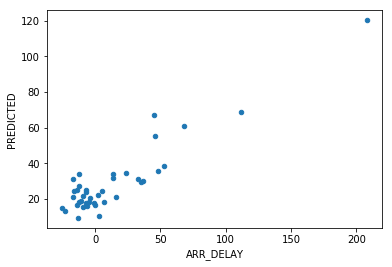

In [132]:
%matplotlib inline
compare=sample.copy()
predicted = estimator(sample.to_dict(orient='list'))
compare['PREDICTED'] = predicted['output']
compare.plot.scatter(x='ARR_DELAY', y='PREDICTED')